Import requried libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB2,EfficientNetB3,EfficientNetB5,InceptionResNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
import keras
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import random

In [3]:
#!pip install tf-nightly
#!pip install keras_efficientnets
#!pip install pretty-confusion-matrix

installing updated version of tensorflow as last one is not working 

In [4]:
!pip install tensorflow==2.8
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 668.3 MB 18 kB/s 
     |████████████████████████████████| 462 kB 15.5 MB/s 
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.2+zzzcolab20220719082949
    Uninstalling tensorflow-2.8.2+zzzcolab20220719082949:
      Successfully uninstalled tensorflow-2.8.2+zzzcolab20220719082949


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8
1 upgraded, 0 newly installed, 1 to remove and 18 not upgraded.
Need to get 430 MB of archives.
After this operation, 3,139 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 7s (60.6 MB/s)
(Reading database ... 155676 files and directories currently installed.)
Removing libcudnn8-dev (8.0.5.39-1+cuda11.1) ...
(Reading database ... 155654 files and directories currently installed.)
Preparing to unpack .../libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb ...
Unpacking libcudnn8 (8.1.0.77-1+c

Create labels and import datasets from drive

In [3]:
#create labels and import dataset from drive
classes=[]
datafile='/content/drive/MyDrive/PROJECT 2022/Brain tumor MRI/archive'
for sub_folder in os.listdir(os.path.join(datafile,'/content/drive/MyDrive/PROJECT 2022/Brain tumor MRI/archive/Training')):
    classes.append(sub_folder)
print(classes)

['pituitary_tumor', 'glioma_tumor', 'meningioma_tumor', 'no_tumor']


Resize images and put together Training and Testing folder

In [4]:
Training_X = []
y_train = []
image_size = 160
for i in classes:
    path_train = os.path.join(datafile,'/content/drive/MyDrive/PROJECT 2022/Brain tumor MRI/archive/Training',i)
    for j in tqdm(os.listdir(path_train)): #use a for loop to work it faster
        img = cv2.imread(os.path.join(path_train,j))
        img = cv2.resize(img,(image_size, image_size))
        Training_X.append(img)
        y_train.append(i)
    path_test = os.path.join(datafile,'/content/drive/MyDrive/PROJECT 2022/Brain tumor MRI/archive/Testing',i)
    for j in tqdm(os.listdir(path_test)):
        img = cv2.imread(os.path.join(path_test,j))
        img = cv2.resize(img,(image_size,image_size))
        Training_X.append(img)
        y_train.append(i)
        
Training_X = np.array(Training_X)
y_train = np.array(y_train)    

100%|██████████| 105/105 [00:01<00:00, 84.35it/s] 


Data augmentation and splitting

In [5]:
#data augmentation
Training_X, y_train = shuffle(Training_X,y_train, random_state=42)
datagen = ImageDataGenerator(
    rotation_range=7, #rotate images by 7
    width_shift_range=0.05,
    height_shift_range=0.05, #shift the giving images in horizontal and vertical
    zoom_range=0.1, 
    horizontal_flip=True)

datagen.fit(Training_X)
Training_X.shape
lb = LabelEncoder()



splitting the train and testing datsets

In [6]:
#train and test splitting 
Training_X,X_test,y_train,y_test = train_test_split(Training_X,y_train, test_size=0.15,random_state=42,stratify=y_train)

labels_train=lb.fit(y_train)
y_train=lb.transform(y_train)
y_test=lb.transform(y_test)

Load EfficientNetB3

In [7]:
print(y_train)

#load EfficientNetNB3
EfficientNet=EfficientNetB3(weights='imagenet', include_top=False,input_shape=(image_size,image_size,3))

[3 1 1 ... 3 3 0]
43950080/43941136 [==============================] - 0s 0us/step


Train the model using activation fuction , max pooling other needed methods

In [8]:
#train the model
tf.random.set_seed(77)
tf.random.set_seed(79)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='elu',kernel_initializer='GlorotNormal', input_shape=(image_size,image_size, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3)),#activation='linear'),
    tf.keras.layers.Activation('linear'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='elu',kernel_initializer='GlorotNormal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='elu',kernel_initializer='GlorotNormal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='elu',kernel_initializer='GlorotNormal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.15),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(500, activation='elu',kernel_initializer='GlorotNormal'),
    tf.keras.layers.Dropout(rate=0.15),
    tf.keras.layers.Dense(38, activation='elu',kernel_initializer='GlorotNormal'),
    tf.keras.layers.Dropout(rate=0.15),
    tf.keras.layers.Dense(4, activation='sigmoid')
      ])
opt = Adam(
    learning_rate=0.00007,
    epsilon=1e-08)

model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy']) 



Summarize the model and fit the mdel in validation

In [13]:
# summarize the model
print(model.summary())
# fit the model
early_stopping_cb=keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)


history=model.fit(Training_X ,y_train,validation_data = (X_test,y_test),epochs=300,
    batch_size=8,callbacks=[early_stopping_cb])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 158, 158, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 158, 158, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 79, 79, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 77, 77, 32)        4640      
                                                                 
 activation (Activation)     (None, 77, 77, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 38, 38, 32)       0

In [11]:
y_train.shape,y_test.shape

((2774,), (490,))

In [10]:
# summarize the model
print(model.summary())
# fit the model
early_stopping_cb=keras.callbacks.EarlyStopping(patience=15,restore_best_weights=True)


history=model.fit(Training_X ,y_train,validation_data = (X_test,y_test),epochs=400,
    batch_size=10,callbacks=[early_stopping_cb])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 158, 158, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 158, 158, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 79, 79, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 77, 77, 32)        4640      
                                                                 
 activation (Activation)     (None, 77, 77, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 38, 38, 32)       0

In [12]:
y_train.shape,y_test.shape

((2774,), (490,))

Save the trained model 
plot accuracy and loss from the trained model 

16/16 [==============================] - 0s 6ms/step - loss: 0.2721 - accuracy: 0.9306


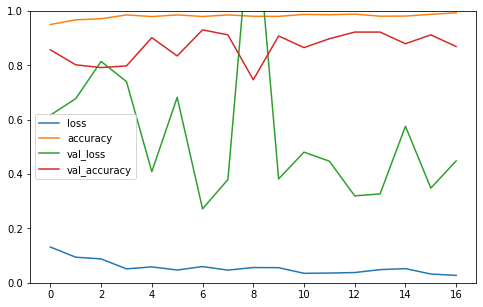

In [14]:

#plot loss and accuracy
pd.DataFrame(history.history).plot(figsize=(8, 5))

plt.gca().set_ylim(0,1)
plt.savefig('/content/drive/MyDrive/PROJECT 2022/Brain tumor MRI/EfficientNetB3.png')
loss, accuracy = model.evaluate(X_test,y_test)


Print the accuracy from the trained data

In [15]:
#print accuracy    
print('Accuracy: %f' % (accuracy*100))

Accuracy: 93.061227


In [16]:
 #load the model
loss, accuracy = model.evaluate(X_test,y_test)

16/16 [==============================] - 0s 6ms/step - loss: 0.2721 - accuracy: 0.9306


Add more details about the model into it 

In [17]:
#  More details about the model
'''
for i, layer in enumerate (model.layers):
    print (i, layer)
    try:
        print ("    ",layer.activation)
    except AttributeError:
        print('   no activation attribute')
#specific info about each layer
for i in range(len(model.layers)):
    print(f'{i}   {model.layers[i]}: \n{model.layers[i].get_config()} \n')
'''
#info about optimizers
model.optimizer.get_config()  

{'name': 'Adam',
 'learning_rate': 7e-05,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-08,
 'amsgrad': False}

Accuracy and Loss 

In [18]:
print(f'accuracy : {round(accuracy*100,3)} \n loss : {round(loss,3)}')

accuracy : 93.061 
 loss : 0.272


predict the values of the tumour with labels

In [19]:
y_test_labels=lb.inverse_transform(y_test)

#predicted values
pred=np.argmax(model.predict(X_test),axis=1)
pred_labels=lb.inverse_transform(pred) #predicted labels

In [20]:
pd.Series(pred_labels).value_counts()

meningioma_tumor    145
pituitary_tumor     137
glioma_tumor        124
no_tumor             84
dtype: int64

Confusion Matrix - predict the class 

Text(70.8, 0.5, 'Predicted class')

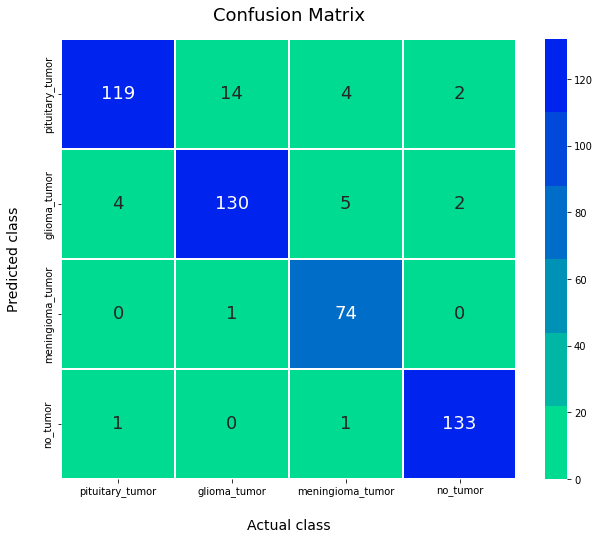

In [21]:
cm = confusion_matrix(y_test,pred)
fig,ax= plt.subplots(figsize=(10.2,8.1))
a=sns.color_palette("winter_r") 
sns.heatmap(cm, annot=True,fmt='g',linewidths=1,linecolor='white',robust=True,annot_kws={"size":18},cmap=a)

ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);
plt.yticks(va="center")
plt.title('Confusion Matrix',fontsize=18,pad=18)
plt.xlabel('Actual class',labelpad=22,fontsize=14)
plt.ylabel('Predicted class',labelpad=22,fontsize=14)


Model performance scores


In [22]:
print(classification_report(y_test,pred,target_names=classes))

                  precision    recall  f1-score   support

 pituitary_tumor       0.96      0.86      0.90       139
    glioma_tumor       0.90      0.92      0.91       141
meningioma_tumor       0.88      0.99      0.93        75
        no_tumor       0.97      0.99      0.98       135

        accuracy                           0.93       490
       macro avg       0.93      0.94      0.93       490
    weighted avg       0.93      0.93      0.93       490



Import the predcited values and name of the class fromt he trained model


In [23]:
import matplotlib.image as mpimg
os.chdir('/content/drive/MyDrive/PROJECT 2022/Brain tumor MRI')
TEST_DIR='/content/drive/MyDrive/PROJECT 2022/Brain tumor MRI/archive/Testing'

#get the images from the original validation dataset 
images=[] 
n_classes=4
z_max=20
for i,filenames in enumerate(os.listdir(TEST_DIR)): 
    dir_fold=os.path.join(TEST_DIR, filenames)
    print(dir_fold)
    class_images=[]
    z=0
    for filename in os.listdir(dir_fold):
        if z < z_max:
            img_path = os.path.join(dir_fold, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img,(image_size,image_size)) # resize the images in order to plot the images from it
            class_images.append(img)
            z+=1
        else:
            break
    images.append(class_images)
images=images[:20]

/content/drive/MyDrive/PROJECT 2022/Brain tumor MRI/archive/Testing/pituitary_tumor
/content/drive/MyDrive/PROJECT 2022/Brain tumor MRI/archive/Testing/meningioma_tumor
/content/drive/MyDrive/PROJECT 2022/Brain tumor MRI/archive/Testing/no_tumor
/content/drive/MyDrive/PROJECT 2022/Brain tumor MRI/archive/Testing/glioma_tumor


Plotting the images from the trained model

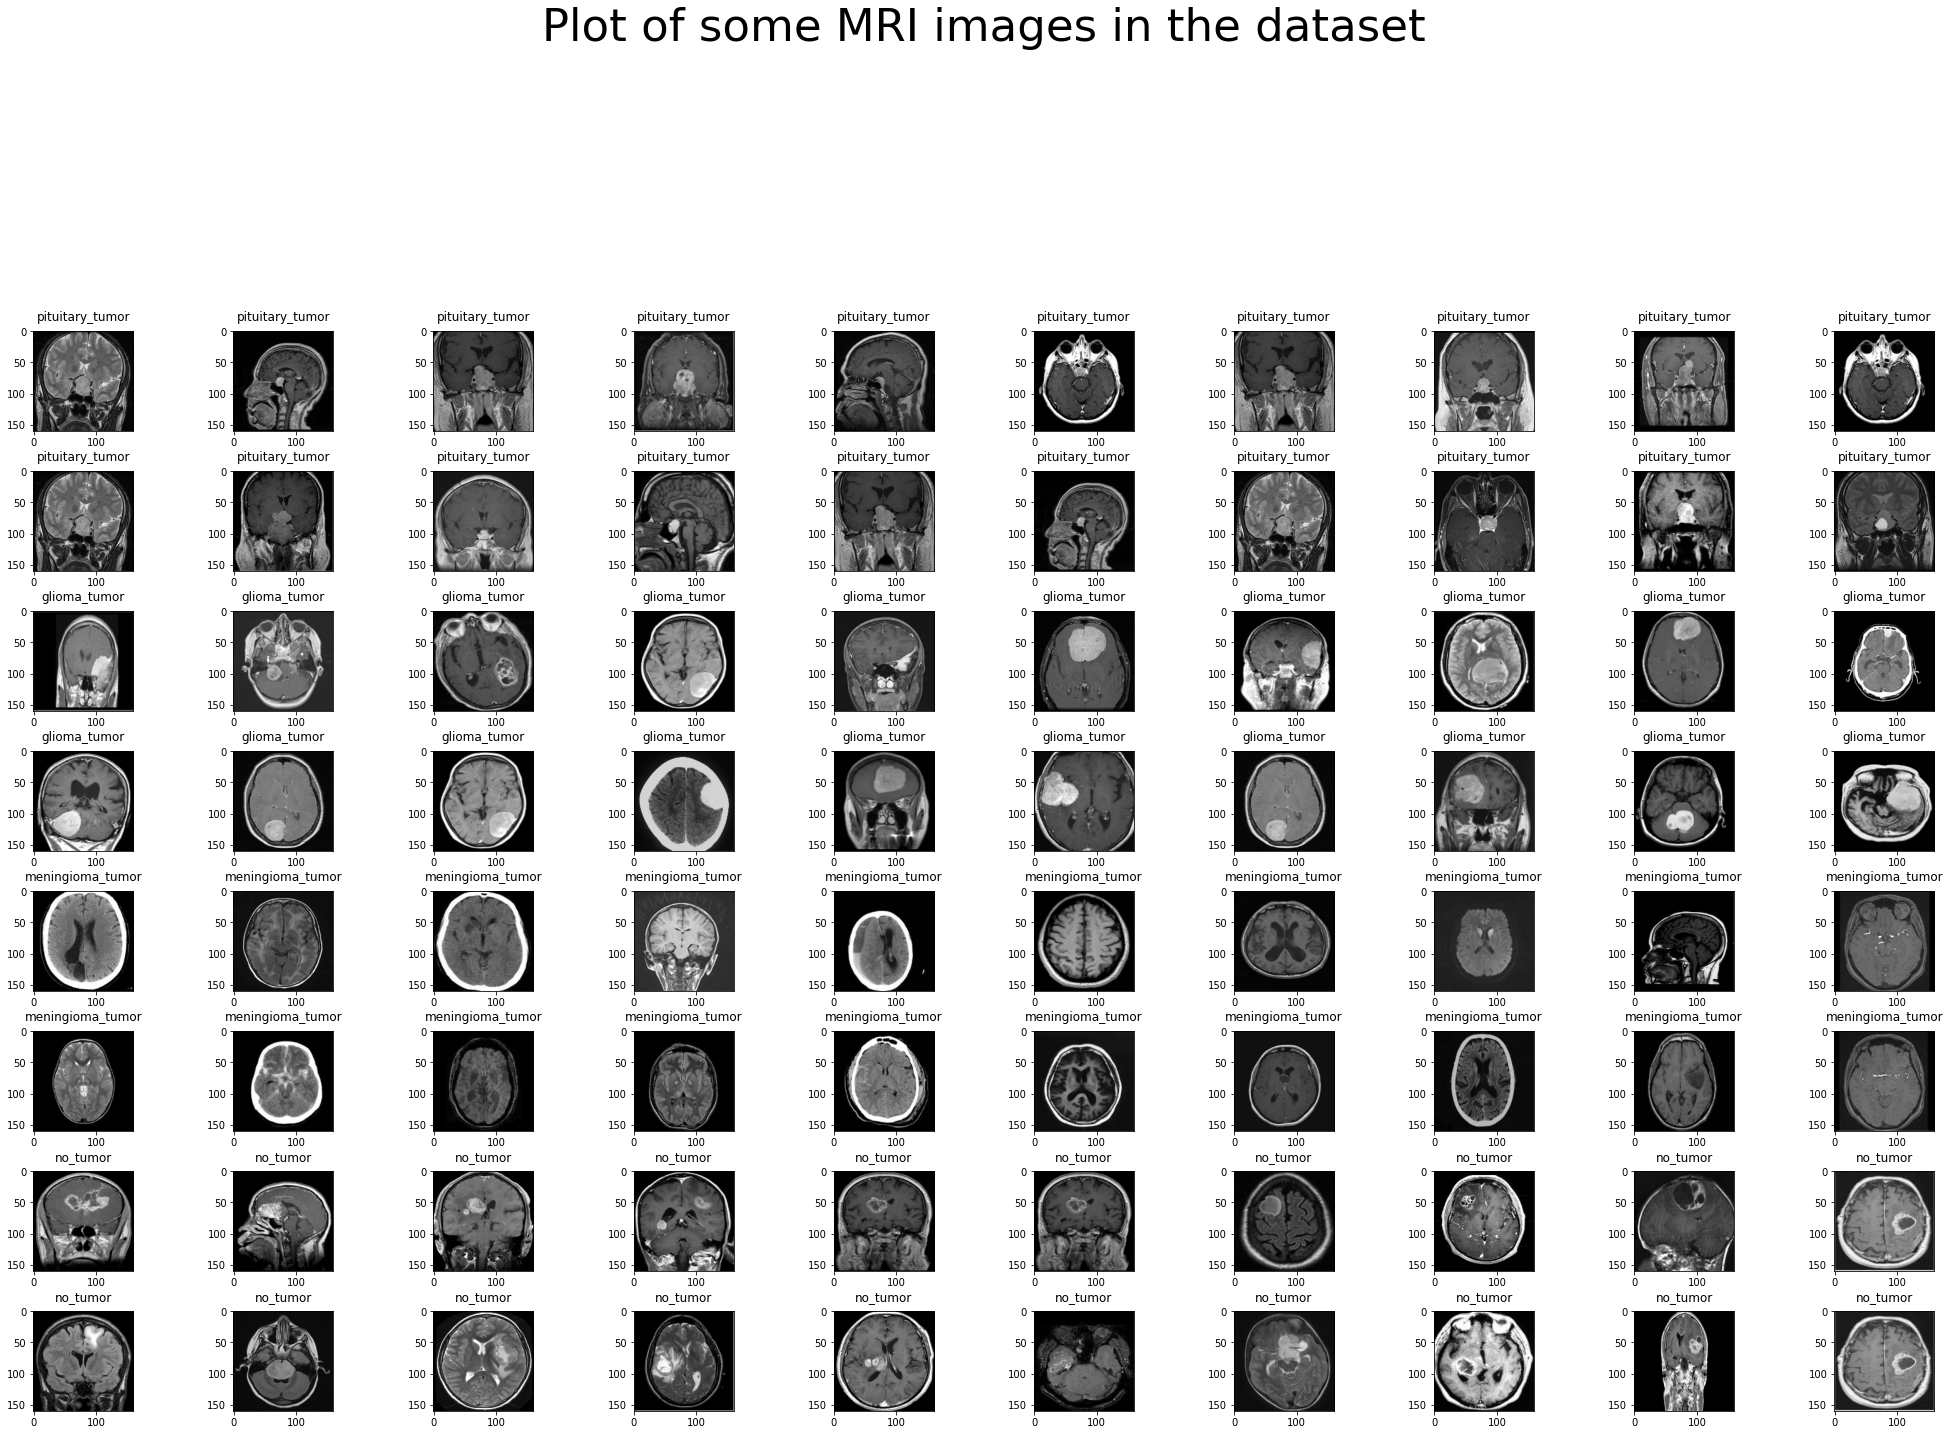

In [24]:
#plotted the images based on z-max and columns
#we can also plot more images witht he help of columns if want to plot more

columns = 10
fig,axes=plt.subplots(int(len(images)*len(images[0])/columns),columns,figsize=(45,25))
fig.subplots_adjust(left=0.2,
                    bottom=0.2, 
                    right=0.8, 
                    top=0.8, 
                    wspace=0.4, 
                    hspace=0.4)
for i,ind in enumerate(images):
    fig.suptitle('Plot of some MRI images in the dataset',fontsize=45) #Plot of some MRI images in the dataset
    for j, image in enumerate(ind):
        axes[int((i)*(len(ind)/columns)+(int(j/columns))),j % columns].imshow(image)
        axes[int((i)*(len(ind)/columns)+(int(j/columns))),j % columns].set_title(f'{classes[i]}',pad=10)


In [25]:
X_test_images=dict(zip(classes,[[],[],[],[]]))
for y,ele in enumerate(pred):
    for i,x in enumerate(X_test_images):
      
        if ele==i:
            if len(X_test_images[classes[i]])<z_max:
                X_test_images[classes[i]].append(X_test[y])
X_test_images=[X_test_images[i]  for i in X_test_images]

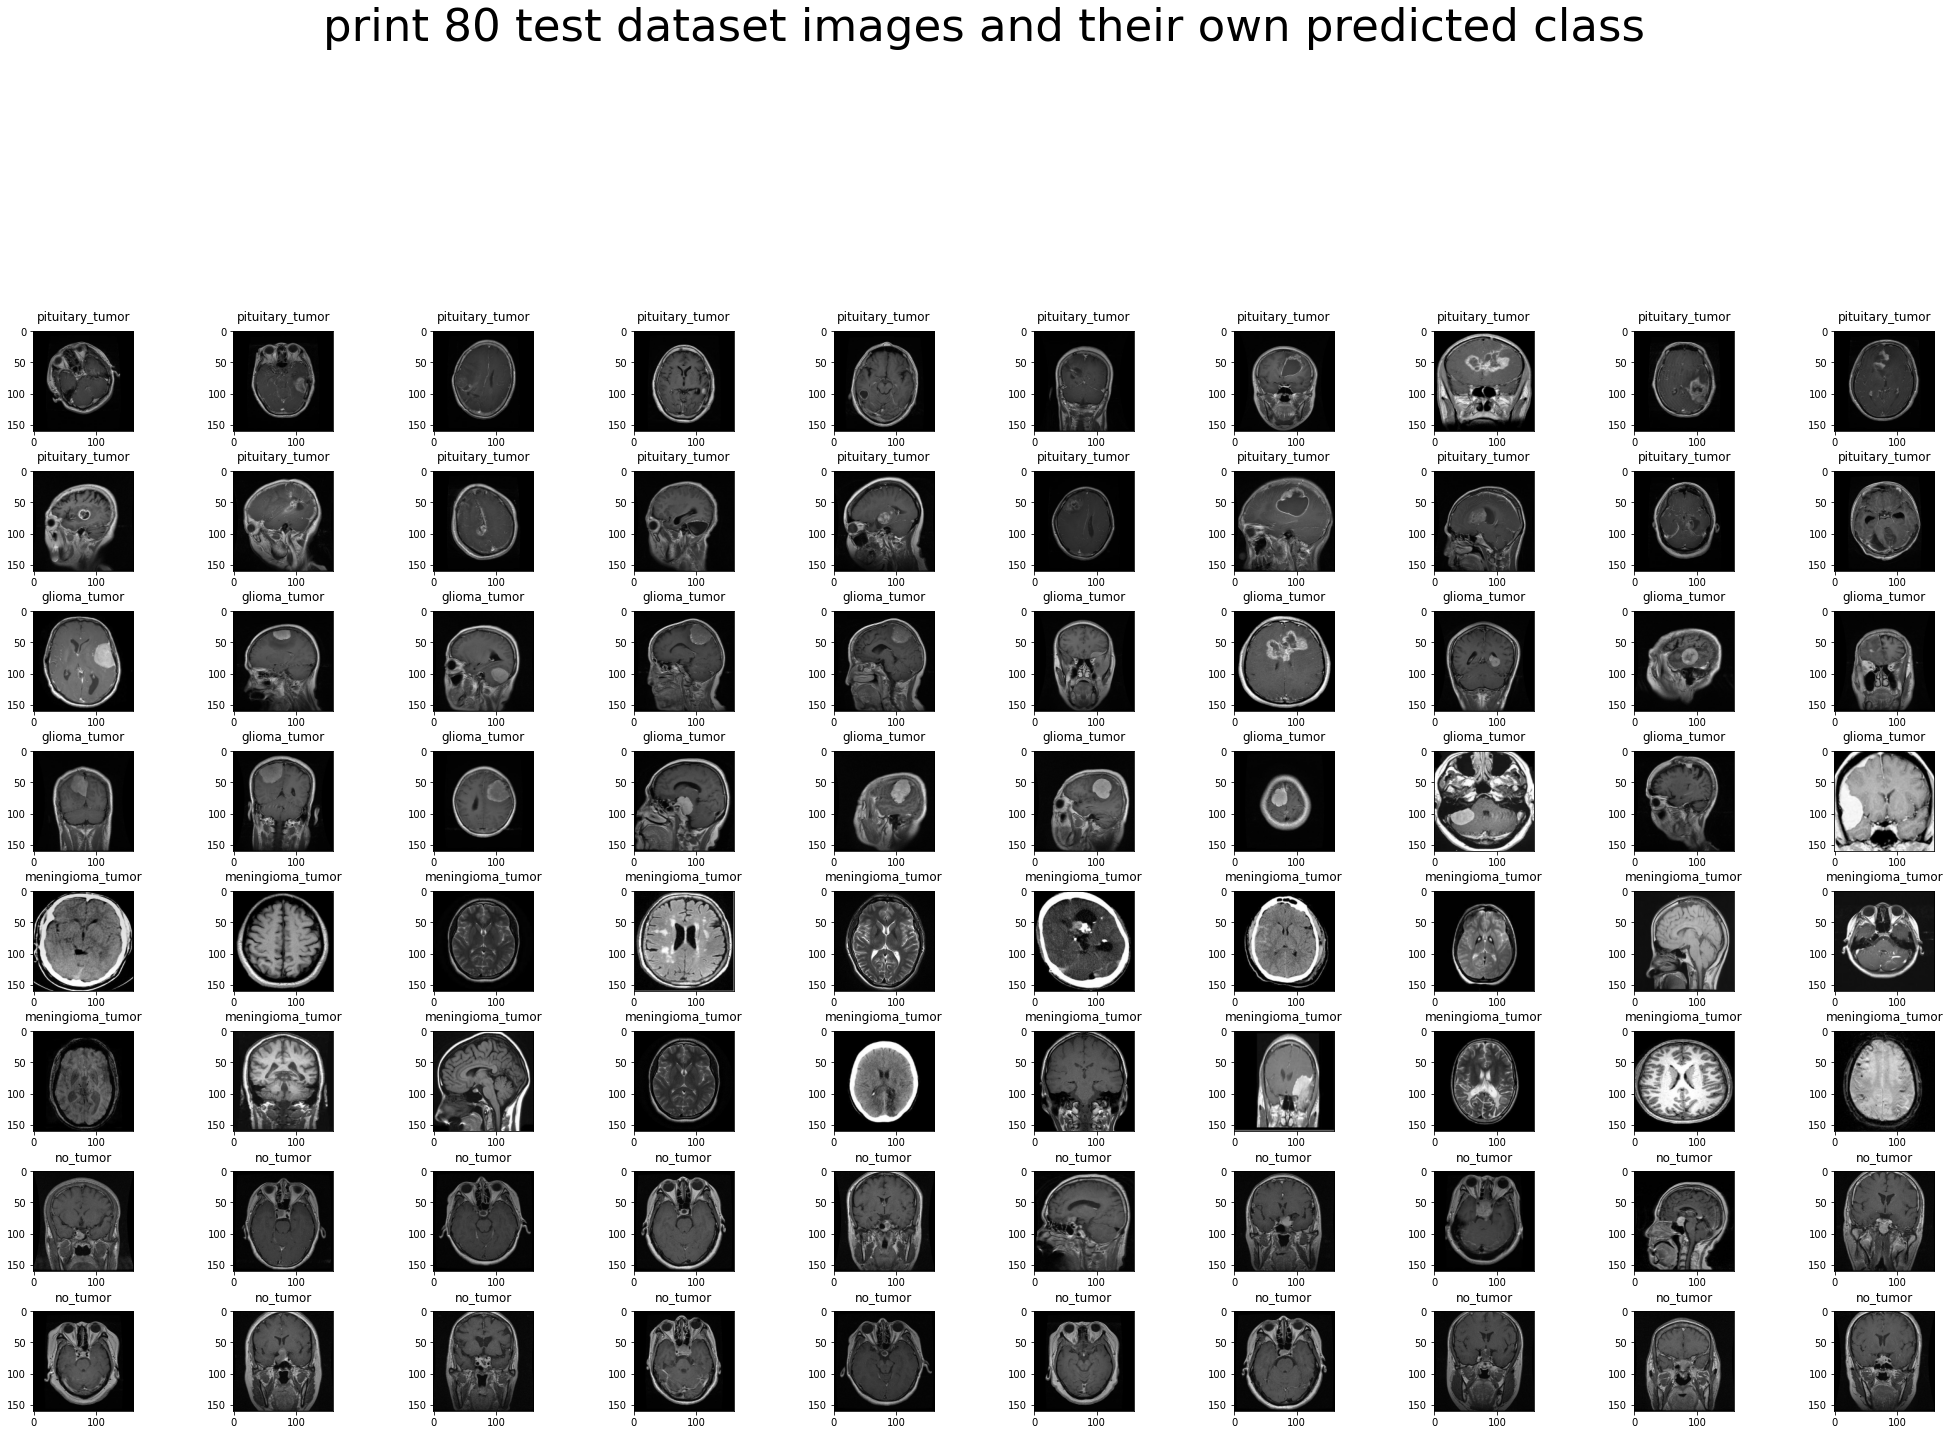

In [26]:
columns = 10
fig,axes=plt.subplots(int(len(X_test_images)*len(X_test_images[0])/columns),columns,figsize=(45,25))
fig.subplots_adjust(left=0.2,
                    bottom=0.2, 
                    right=0.8, 
                    top=0.8, 
                    wspace=0.4, 
                    hspace=0.4)
for i,ind in enumerate(X_test_images):
    
    fig.suptitle('print 80 test dataset images and their own predicted class',fontsize=45) #print 80 test dataset images and their own predicted class
    for j, image in enumerate(ind):
        if int((i)*(len(ind)/columns)+(int(j/columns)))<n_classes*(z_max/columns):
            axes[int((i)*(len(ind)/columns)+(int(j/columns))),j % columns].imshow(image)
            axes[int((i)*(len(ind)/columns)+(int(j/columns))),j % columns].set_title(f'{classes[i]}',pad=10)

In [27]:
X_test.shape

(490, 160, 160, 3)